In [1]:
import scanpy as sc
import anndata
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix
import numpy as np
import os
import pandas as pd

import scvelo as scv
import cellrank as cr
import anndata as ad

scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo', facecolor='white', dpi=150, frameon=False)
cr.settings.verbosity = 2

In [2]:
## Step 0: Load Full SC data

In [3]:
# load sparse matrix:
X = io.mmread("/Volumes/ithil/project/2022_yap5sa_st_rli/rdata/mouse_v0/analysis/part91.full.counts_mtx.gz")

In [4]:
# create anndata object
adata = anndata.AnnData(
    X=X.transpose().tocsr()
)

In [5]:
# load cell metadata:
cell_meta = pd.read_csv("/Volumes/ithil/project/2022_yap5sa_st_rli/rdata/mouse_v0/analysis/part91.full.srt_meta.csv.gz",
                        compression='gzip')


In [6]:
# load gene names:
with open("/Volumes/ithil/project/2022_yap5sa_st_rli/rdata/mouse_v0/analysis/part91.full.gene_names.csv", 'r') as f:
    gene_names = f.read().splitlines()
gene_names.pop(0)

'rownames(drop2.srt)'

In [7]:
# set anndata observations and index obs by barcodes, var by gene names
adata.obs = cell_meta
adata.obs.index = adata.obs['barcode']
adata.var.index = gene_names

In [8]:
# load dimensional reduction:
pca = pd.read_csv("/Volumes/ithil/project/2022_yap5sa_st_rli/rdata/mouse_v0/analysis/part91.full_harmony.srt_dim.csv.gz",
                 compression='gzip')
pca.index = adata.obs.index

In [9]:
# set pca and umap
adata.obsm['X_pca'] = pca.to_numpy()
adata.obsm['X_umap'] = np.vstack((adata.obs['UMAP_1'].to_numpy(), adata.obs['UMAP_2'].to_numpy())).T
adata.obsm['X_subumap'] = np.vstack((adata.obs['SUBUMAP_1'].to_numpy(), adata.obs['SUBUMAP_2'].to_numpy())).T

/Users/Felix/opt/anaconda3/envs/cellrank/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


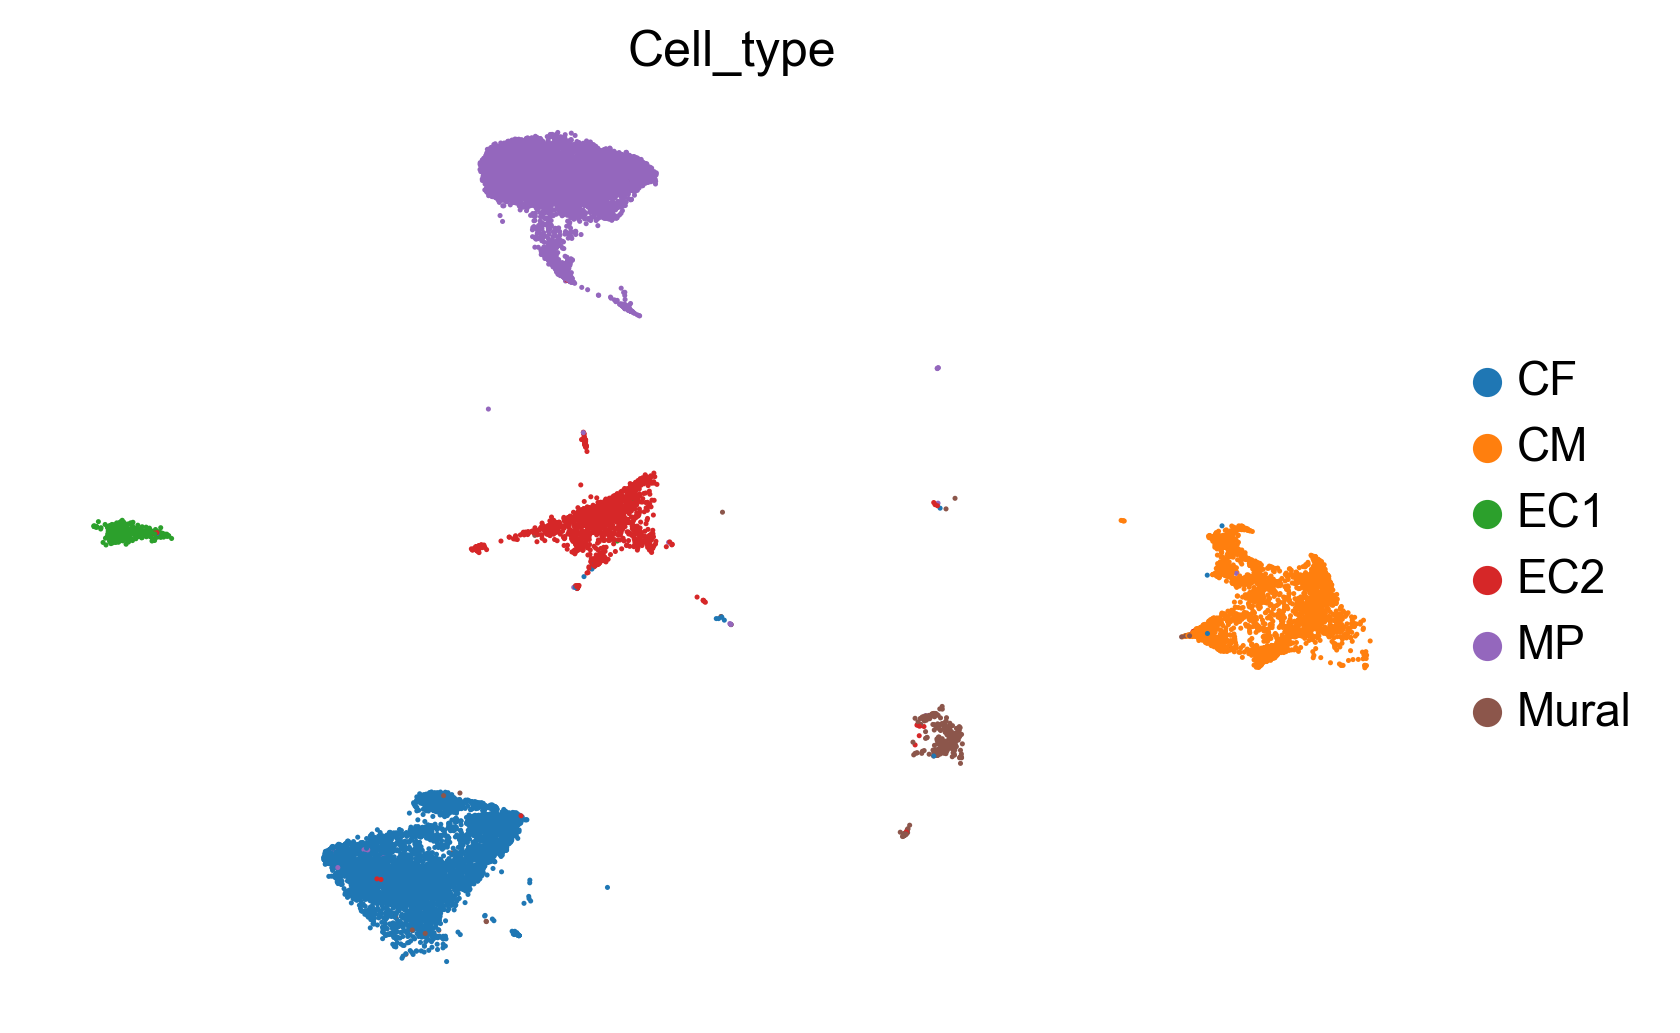

In [10]:
# plot a UMAP colored by sampleID to test:
sc.pl.umap(adata, color=['Cell_type'], frameon=False)

/Users/Felix/opt/anaconda3/envs/cellrank/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


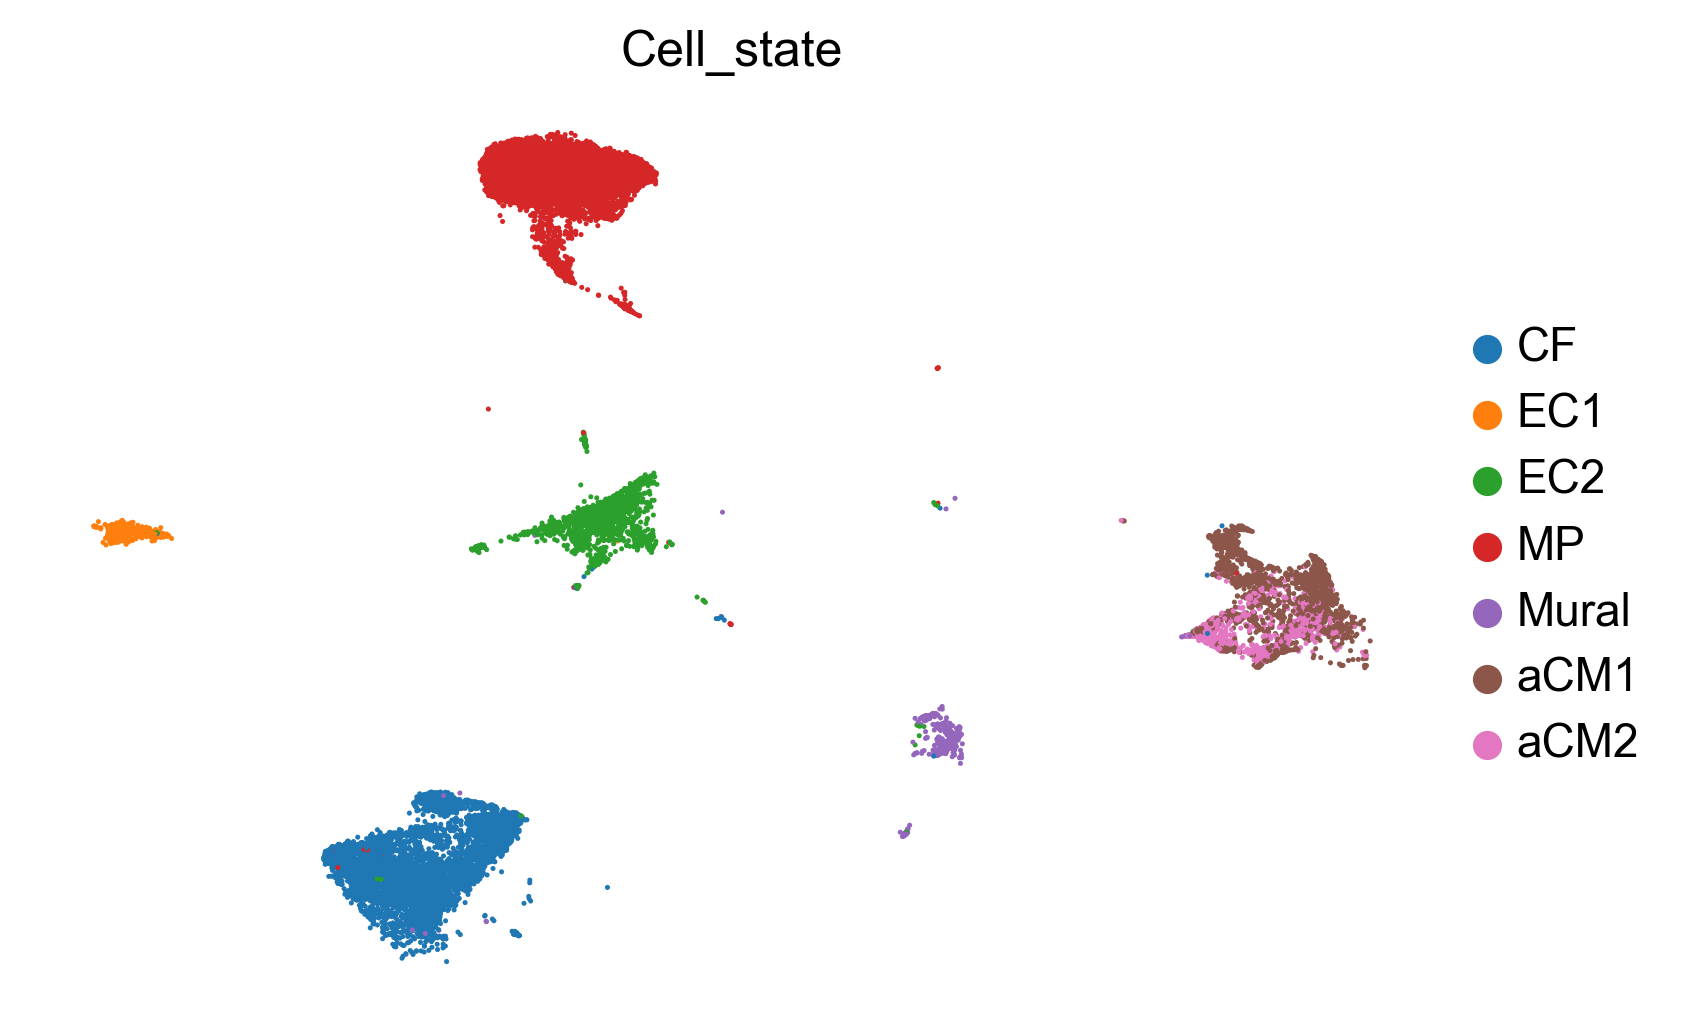

In [11]:
sc.pl.umap(adata, color=['Cell_state'], frameon=False)

In [12]:
# save dataset as anndata format
adata.write('/Volumes/ithil/project/2022_yap5sa_st_rli/rdata/mouse_v0/tmp/part91.full_scvelo.h5ad')

In [13]:
# reload dataset
# adata = sc.read_h5ad('/Volumes/ithil/project/2022_yap5sa_st_rli/rdata/mouse_v0/tmp/part91.full_scvelo.h5ad')

In [14]:
## Step 1: Load Velocyto data

In [15]:
# load loom files for spliced/unspliced matrices for each sample:
path1="/Volumes/shire/data/scrnaseq/"
path2="matrix/velocyto/"
Ctrl_01_loom_data1 = scv.read(path1+"2017_Unpub4_JMartin/"+path2+"ctrl_cm_s1.loom")
Ctrl_02_loom_data2 = scv.read(path1+"2017_Unpub4_JMartin/"+path2+"ctrl_wh_s1.loom")
Ctrl_03_loom_data3 = scv.read(path1+"2017_Unpub4_JMartin/"+path2+"ctrl_wh_s2.loom")
Y5sa_01_loom_data1 = scv.read(path1+"2017_Unpub4_JMartin/"+path2+"yap5sa_cm_s1.loom")
Y5sa_02_loom_data2 = scv.read(path1+"2017_Unpub4_JMartin/"+path2+"yap5sa_wh_s1.loom")
Y5sa_03_loom_data3 = scv.read(path1+"2017_Unpub4_JMartin/"+path2+"yap5sa_wh_s2.loom")

/Users/Felix/opt/anaconda3/envs/cellrank/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/Felix/opt/anaconda3/envs/cellrank/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/Felix/opt/anaconda3/envs/cellrank/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/Felix/opt/anaconda3/envs/cellrank/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/Felix/opt/anaconda3/envs/cellrank/lib/python3.8/site-packages

In [16]:
## Rename all loom cell names to match the adata
barcodes = [bc.split(':')[1] for bc in Ctrl_01_loom_data1.obs.index.tolist()]
Ctrl_01_loom_data1.index = [bc[0:len(bc)-1] + '_1' for bc in barcodes]
barcodes = [bc.split(':')[1] for bc in Ctrl_02_loom_data2.obs.index.tolist()]
Ctrl_02_loom_data2.index = [bc[0:len(bc)-1] + '_2' for bc in barcodes]
barcodes = [bc.split(':')[1] for bc in Ctrl_03_loom_data3.obs.index.tolist()]
Ctrl_03_loom_data3.index = [bc[0:len(bc)-1] + '_3' for bc in barcodes]
barcodes = [bc.split(':')[1] for bc in Y5sa_01_loom_data1.obs.index.tolist()]
Y5sa_01_loom_data1.index = [bc[0:len(bc)-1] + '_4' for bc in barcodes]
barcodes = [bc.split(':')[1] for bc in Y5sa_02_loom_data2.obs.index.tolist()]
Y5sa_02_loom_data2.index = [bc[0:len(bc)-1] + '_5' for bc in barcodes]
barcodes = [bc.split(':')[1] for bc in Y5sa_03_loom_data3.obs.index.tolist()]
Y5sa_03_loom_data3.index = [bc[0:len(bc)-1] + '_6' for bc in barcodes]


In [17]:
# make variable names unique
Ctrl_01_loom_data1.var_names_make_unique()
Ctrl_02_loom_data2.var_names_make_unique()
Ctrl_03_loom_data3.var_names_make_unique()
Y5sa_01_loom_data1.var_names_make_unique()
Y5sa_02_loom_data2.var_names_make_unique()
Y5sa_03_loom_data3.var_names_make_unique()

In [18]:
# concatenate the three loom
ldata = Ctrl_01_loom_data1.concatenate([Ctrl_02_loom_data2, Ctrl_03_loom_data3, 
                                        Y5sa_01_loom_data1, Y5sa_02_loom_data2, Y5sa_03_loom_data3])

In [19]:
ldata

AnnData object with n_obs × n_vars = 17991 × 36601
    obs: 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [20]:
adata

AnnData object with n_obs × n_vars = 20301 × 57821
    obs: 'group1', 'group2', 'Cell_type', 'Cell_state', 'barcode', 'UMAP_1', 'UMAP_2', 'SUBUMAP_1', 'SUBUMAP_2'
    uns: 'Cell_type_colors', 'Cell_state_colors'
    obsm: 'X_pca', 'X_umap', 'X_subumap'

IndexError: Unknown indexer AnnData object with n_obs × n_vars = 17991 × 36601
    obs: 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced' of type <class 'anndata._core.anndata.AnnData'>

In [21]:
# merge matrices into the original adata object
adata = scv.utils.merge(adata, ldata)

ValueError: Length of passed value for var_names is 27231, but this AnnData has shape: (20301, 57821)

In [ ]:
# plot umap to check
sc.pl.umap(adata, color='Cell_type', frameon=False, legend_loc='on data', title='')

In [ ]:
## Step 2: Computing RNA velocity using scVelo

In [ ]:
scv.pl.proportions(adata, groupby='Cell_state')

In [ ]:
# pre-process
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata)

In [ ]:
# save dataset
adata.write('/Volumes/ithil/project/2022_yap5sa_st_rli/rdata/mouse_v0/analysis/part91.full_scvelo.h5ad')

In [ ]:
#### End of full data processing ####

In [ ]:
#### Analysing Fibroblast subset ####

In [ ]:
# reload dataset
adata = sc.read_h5ad('/Volumes/ithil/project/2022_yap5sa_st_rli/rdata/mouse_v0/analysis/part91.full_scvelo.h5ad')

In [ ]:
# subset for Cardiomyocytes
sub_adata = adata[adata.obs['Cell_type'] == 'CM']

In [ ]:
sub_adata = adata

In [ ]:
# check dim reduction
sc.pl.embedding(sub_adata, color='Cell_state', frameon=False, legend_loc='on data', title='', basis='subumap')

In [ ]:
# compute velocity using stochastic mode
scv.tl.velocity(sub_adata, mode = 'stochastic')

# or
# compute velocity using dynamical mode
#scv.tl.recover_dynamics(sub_adata, n_jobs = 1)
#scv.tl.velocity(sub_adata, mode = 'dynamical')

In [ ]:
scv.pp.neighbors(sub_adata)
scv.tl.velocity_graph(sub_adata)

In [ ]:
scv.pl.velocity_embedding_grid(sub_adata, basis='subumap', color='Cell_state', title='',
                               scale = 0.2, density = 0.3, smooth = 0.5, min_mass = 5, 
                               arrow_length = 3, arrow_size = 4, linecolor = '##000000',
                               save='fb.scvelo_embedding.pdf', figsize=(5,5))

In [ ]:
scv.pl.velocity_embedding_stream(sub_adata, basis='subumap', color=['Cell_state'], title='',
                                 min_mass=0.8, density=1,
                                 save='fb.embedding_stream.pdf', figsize=(5,5))

In [ ]:
# plot velocity of a selected gene
scv.pl.velocity(sub_adata, var_names=['PTX3'], color='Cell_state', basis='subumap',
                save='fb.PTX3_dynamics.pdf', figsize=(5,5))

In [ ]:
# PAGA analysis
scv.tl.rank_velocity_genes(sub_adata, groupby='Cell_state', min_corr=.3)

In [ ]:
sub_adata.uns['neighbors']['distances'] = sub_adata.obsp['distances']
sub_adata.uns['neighbors']['connectivities'] = sub_adata.obsp['connectivities']
scv.tl.paga(sub_adata, groups='Cell_state', minimum_spanning_tree=1)

In [ ]:
scv.pl.paga(sub_adata, basis='subumap', size=30, alpha=.1, min_edge_width=2, node_size_scale=1.5, threshold=0,
            #save='fb.paga.pdf', figsize=(5,5)
           )

In [ ]:
# latent time
scv.tl.recover_dynamics(sub_adata, n_jobs = 30) ## run this only when using stochastic mode
scv.tl.latent_time(sub_adata)

In [ ]:
# pseudo time
scv.tl.velocity_pseudotime(sub_adata)

In [ ]:
scv.pl.scatter(sub_adata, color=['latent_time', 'velocity_pseudotime'], 
               color_map='viridis', size=30, basis='subumap',
               save='fb.dynamical_latent_time.pdf', figsize=(5,5))

In [ ]:
# Velocity and Inference Confidence analysis
scv.tl.velocity_confidence(sub_adata)

In [ ]:
keys = 'velocity_length', 'velocity_confidence' ## Speed: length of the velocity vector Coherence: how well a velocity vector correlates to its neighbors
scv.pl.scatter(sub_adata, c=keys, cmap='coolwarm', perc=[5, 95], size = 30, basis='subumap',
               save='fb.velocity_length_confidence.pdf', figsize=(5,5))

In [ ]:
# Plot Velocity Graph (has bug -- not used)
# scv.pl.velocity_graph(sub_adata, threshold=0.2, color='Cell_state', which_graph='connectivities', basis='subumap')

In [ ]:
# get top latent time-correlated genes
top_genes = sub_adata.var['fit_likelihood'].sort_values(ascending=False).index[:200]

In [ ]:
top_genes

In [ ]:
scv.pl.heatmap(sub_adata, var_names=top_genes, sortby='latent_time', col_color='Cell_state', n_convolve=100, 
               save='fb.latent_time_fit_genes.png', figsize=(10,10))

In [ ]:
var_names = ['PTX3', 'LMNA', 'IL1R1']
scv.pl.scatter(sub_adata, var_names, color='Cell_state', frameon=False,
              save='fb.latent_time_fit_genes_velocity.pdf', figsize=(3,3))
scv.pl.scatter(sub_adata, x='latent_time', y=var_names, color='Cell_state', frameon=False,
              save='fb.latent_time_fit_genes_across_time.pdf', figsize=(3,3))

In [ ]:
# save dataset
sub_adata.write('/Volumes/bree/project/2022_hlhs_dturaga/rdata/human_v0/analysis/PART24.fb_scvelo.h5ad')

In [ ]:
#### End of fibroblast analysis ####

In [ ]:
#### Analysing Myeloid subset ####

In [ ]:
# reload dataset
adata = sc.read_h5ad('/Volumes/bree/project/2022_hlhs_dturaga/rdata/human_v0/analysis/PART24.full_scvelo.h5ad')

In [ ]:
# subset for Myeloid cells
mye_adata = adata[adata.obs['Cell_type'] == 'Mye']

In [ ]:
mye_adata = mye_adata[mye_adata.obs['Non_ambiguous'] == True]

In [ ]:
mye_adata

In [ ]:
# check dim reduction
sc.pl.embedding(mye_adata, color='Cell_state', frameon=False, legend_loc='on data', title='', basis='subumap')

In [ ]:
# compute velocity using stochastic mode
#scv.tl.velocity(mye_adata, mode = 'stochastic')

# or
# compute velocity using dynamical mode
scv.tl.recover_dynamics(mye_adata, n_jobs = 30)
scv.tl.velocity(mye_adata, mode = 'dynamical')

In [ ]:
scv.pp.neighbors(mye_adata)
scv.tl.velocity_graph(mye_adata)

In [ ]:
scv.pl.velocity_embedding_grid(mye_adata, basis='subumap', color='Cell_state', title='', scale=0.25, 
                               save='mye.scvelo_embedding.pdf', figsize=(5,5))

In [ ]:
scv.pl.velocity_embedding_stream(mye_adata, basis='subumap', color=['Cell_state'], title='',
                                 min_mass=0.8, density=1,
                                 save='mye.embedding_stream.pdf', figsize=(3,3))

In [ ]:
# plot velocity of a selected gene
scv.pl.velocity(mye_adata, var_names=['NLRP3'], color='Cell_state', basis='subumap',
                save='mye.NAMPT_dynamics.pdf', figsize=(5,5))

In [ ]:
# latent time
scv.tl.latent_time(mye_adata)

In [ ]:
# pseudo time
scv.tl.velocity_pseudotime(mye_adata)

In [ ]:
scv.pl.scatter(mye_adata, color=['latent_time', 'velocity_pseudotime'], 
               color_map='viridis', size=40, basis='subumap',
               save='mye.dynamical_latent_time.pdf', figsize=(5,5))

In [ ]:
# PAGA analysis
scv.tl.rank_velocity_genes(mye_adata, groupby='Cell_state', min_corr=.3)

In [ ]:
mye_adata.uns['neighbors']['distances'] = mye_adata.obsp['distances']
mye_adata.uns['neighbors']['connectivities'] = mye_adata.obsp['connectivities']
scv.tl.paga(mye_adata, groups='Cell_state')

In [ ]:
scv.pl.paga(mye_adata, basis='subumap', size=30, alpha=.1, min_edge_width=2, node_size_scale=1.5, threshold=0,
            save='mye.paga.pdf', figsize=(5,5))

In [ ]:
# Velocity and Inference Confidence analysis
scv.tl.velocity_confidence(mye_adata)

In [ ]:
keys = 'velocity_length', 'velocity_confidence' ## Speed: length of the velocity vector Coherence: how well a velocity vector correlates to its neighbors
scv.pl.scatter(mye_adata, c=keys, cmap='coolwarm', perc=[5, 95], size = 30, basis='subumap',
               save='mye.velocity_length_confidence.pdf', figsize=(5,5))

In [ ]:
# Plot Velocity Graph (has bug -- not used)
# scv.pl.velocity_graph(mye_adata, threshold=0.2, color='Cell_state', which_graph='connectivities', basis='subumap')

In [ ]:
# get top latent time-correlated genes
top_genes = mye_adata.var['fit_likelihood'].sort_values(ascending=False).index[:200]

In [ ]:
top_genes

In [ ]:
scv.pl.heatmap(mye_adata, var_names=top_genes, sortby='latent_time', col_color='Cell_state', n_convolve=100, 
               save='mye.latent_time_fit_genes.png', figsize=(10,10))

In [ ]:
var_names = ['LYVE1', 'NLRP3', 'IL10']
scv.pl.scatter(mye_adata, var_names, color='Cell_state', frameon=False,
              save='mye.latent_time_fit_genes_velocity.pdf', figsize=(3,3))
scv.pl.scatter(mye_adata, x='latent_time', y=var_names, color='Cell_state', frameon=False,
              save='mye.latent_time_fit_genes_across_time.pdf', figsize=(3,3))

In [ ]:
# save dataset
mye_adata.write('/Volumes/bree/project/2022_hlhs_dturaga/rdata/human_v0/analysis/PART24.mye_scvelo.h5ad')

In [ ]:
#### End of myeloid cells analysis ####

In [ ]:
#### Analysing Main Macrophage subset ####

In [ ]:
# reload dataset
adata = sc.read_h5ad('/Volumes/bree/project/2022_hlhs_dturaga/rdata/human_v0/analysis/PART24.full_scvelo.h5ad')

In [ ]:
# subset for Mono+MP1-3
mp_adata = adata[adata.obs['Cell_state'].isin(['Mono', 'MP1', 'MP2', 'MP3'])]

In [ ]:
mp_adata = mp_adata[mp_adata.obs['Non_ambiguous'] == True]

In [ ]:
mp_adata

In [ ]:
# check dim reduction
sc.pl.embedding(mp_adata, color='Cell_state', frameon=False, legend_loc='on data', title='', basis='macumap')

In [ ]:
# compute velocity using stochastic mode
#scv.tl.velocity(mp_adata, mode = 'stochastic')

# or
# compute velocity using dynamical mode
scv.tl.recover_dynamics(mp_adata, n_jobs = 30)
scv.tl.velocity(mp_adata, mode = 'dynamical')

In [ ]:
scv.pp.neighbors(mp_adata)
scv.tl.velocity_graph(mp_adata)

In [ ]:
scv.pl.velocity_embedding_grid(mp_adata, basis='macumap', color='Cell_state', title='',
                               scale = 0.2, density = 0.3, smooth = 0.5, min_mass = 5, 
                               arrow_length = 3, arrow_size = 4, linecolor = '##000000',
                               save='main_mac.scvelo_embedding.pdf', figsize=(5,5))

In [ ]:
scv.pl.velocity_embedding_stream(mp_adata, basis='macumap', color=['Cell_state'], title='',
                                 min_mass=0.8, density=1,
                                 save='main_mac.embedding_stream.pdf', figsize=(3,3))

In [ ]:
# plot velocity of a selected gene
scv.pl.velocity(mp_adata, var_names=['NLRP3'], color='Cell_state', basis='macumap',
                save='main_mac.NAMPT_dynamics.pdf', figsize=(5,5))

In [ ]:
# latent time
scv.tl.latent_time(mp_adata)

In [ ]:
# pseudo time
scv.tl.velocity_pseudotime(mp_adata)

In [ ]:
scv.pl.scatter(mp_adata, color=['latent_time', 'velocity_pseudotime'], 
               color_map='viridis', size=40, basis='macumap',
               save='main_mac.dynamical_latent_time.pdf', figsize=(5,5))

In [ ]:
# PAGA analysis
scv.tl.rank_velocity_genes(mp_adata, groupby='Cell_state', min_corr=.3)

In [ ]:
mp_adata.uns['neighbors']['distances'] = mp_adata.obsp['distances']
mp_adata.uns['neighbors']['connectivities'] = mp_adata.obsp['connectivities']
scv.tl.paga(mp_adata, groups='Cell_state')

In [ ]:
scv.pl.paga(mp_adata, basis='macumap', size=30, alpha=.1, min_edge_width=2, node_size_scale=1.5, threshold=0,
            save='main_mac.paga.pdf', figsize=(5,5))

In [ ]:
# Velocity and Inference Confidence analysis
scv.tl.velocity_confidence(mp_adata)

In [ ]:
keys = 'velocity_length', 'velocity_confidence' ## Speed: length of the velocity vector Coherence: how well a velocity vector correlates to its neighbors
scv.pl.scatter(mp_adata, c=keys, cmap='coolwarm', perc=[5, 95], size = 30, basis='macumap',
               save='main_mac.velocity_length_confidence.pdf', figsize=(5,5))

In [ ]:
# Plot Velocity Graph (has bug -- not used)
# scv.pl.velocity_graph(mp_adata, threshold=0.2, color='Cell_state', which_graph='connectivities', basis='subumap')

In [ ]:
# get top latent time-correlated genes
top_genes = mp_adata.var['fit_likelihood'].sort_values(ascending=False).index[:200]

In [ ]:
top_genes

In [ ]:
scv.pl.heatmap(mp_adata, var_names=top_genes, sortby='latent_time', col_color='Cell_state', n_convolve=100, 
               save='main_mac.latent_time_fit_genes.png', figsize=(10,100))

In [ ]:
var_names = ['LYVE1', 'NLRP3', 'IL10']
scv.pl.scatter(mp_adata, var_names, color='Cell_state', frameon=False,
              save='main_mac.latent_time_fit_genes_velocity.pdf', figsize=(3,3))
scv.pl.scatter(mp_adata, x='latent_time', y=var_names, color='Cell_state', frameon=False,
              save='main_mac.latent_time_fit_genes_across_time.pdf', figsize=(3,3))

In [ ]:
# save dataset
mp_adata.write('/Volumes/bree/project/2022_hlhs_dturaga/rdata/human_v0/analysis/PART24.main_mac_scvelo.h5ad')

In [ ]:
# subset for Endothelial Cells
ec_adata = adata[adata.obs['Cell_type'] == 'EC']

In [ ]:
ec_adata = ec_adata[ec_adata.obs['Non_ambiguous'] == True]

In [ ]:
ec_adata

In [ ]:
# check dim reduction
sc.pl.embedding(ec_adata, color='Cell_state', frameon=False, legend_loc='on data', title='', basis='subumap')

In [ ]:
# compute velocity using stochastic mode
scv.tl.velocity(ec_adata, mode = 'stochastic')

# or
# compute velocity using dynamical mode
# scv.tl.recover_dynamics(ec_adata, n_jobs = 30)
# scv.tl.velocity(ec_adata, mode = 'dynamical')

In [ ]:
scv.pp.neighbors(ec_adata)
scv.tl.velocity_graph(ec_adata)

In [ ]:
scv.pl.velocity_embedding_grid(ec_adata, basis='subumap', color='Cell_state', title='',
                               scale = 1, density = 1, smooth = 0.5, min_mass = 5, 
                               arrow_length = 1, arrow_size = 1, linecolor = '##000000',
                               save='ec.scvelo_embedding.pdf', figsize=(5,5))

In [ ]:
scv.pl.velocity_embedding_stream(ec_adata, basis='subumap', color=['Cell_state'], title='',
                                 min_mass=0.2, density=1, 
                                 save='ec.embedding_stream.pdf', figsize=(5,5))

In [ ]:
# plot velocity of a selected gene
scv.pl.velocity(ec_adata, var_names=['HIF1A'], color='Cell_state', basis='subumap',
                save='ec.HIF1A_dynamics.pdf', figsize=(5,5))

In [ ]:
# PAGA analysis
scv.tl.rank_velocity_genes(ec_adata, groupby='Cell_state', min_corr=.3)

In [ ]:
ec_adata.uns['neighbors']['distances'] = ec_adata.obsp['distances']
ec_adata.uns['neighbors']['connectivities'] = ec_adata.obsp['connectivities']
scv.tl.paga(ec_adata, groups='Cell_state', minimum_spanning_tree=1)

In [ ]:
scv.pl.paga(ec_adata, basis='subumap', size=30, alpha=.1, min_edge_width=2, node_size_scale=1.5, threshold=0,
            save='ec.paga.pdf', figsize=(5,5))

In [ ]:
# latent time
scv.tl.recover_dynamics(ec_adata, n_jobs = 30) ## run this only when using stochastic mode
scv.tl.latent_time(ec_adata)

In [ ]:
# pseudo time
scv.tl.velocity_pseudotime(ec_adata)

In [ ]:
scv.pl.scatter(ec_adata, color=['latent_time', 'velocity_pseudotime'], 
               color_map='viridis', size=30, basis='subumap',
               save='ec.dynamical_latent_time.pdf', figsize=(5,5))

In [ ]:
# Velocity and Inference Confidence analysis
scv.tl.velocity_confidence(ec_adata)

In [ ]:
keys = 'velocity_length', 'velocity_confidence' ## Speed: length of the velocity vector Coherence: how well a velocity vector correlates to its neighbors
scv.pl.scatter(ec_adata, c=keys, cmap='coolwarm', perc=[5, 95], size = 30, basis='subumap',
               save='ec.velocity_length_confidence.pdf', figsize=(5,5))

In [ ]:
var_names = ['HIF1A']
scv.pl.scatter(ec_adata, var_names, color='Cell_state', frameon=False,
              save='ec.latent_time_fit_genes_velocity.pdf', figsize=(3,3))
scv.pl.scatter(ec_adata, x='latent_time', y=var_names, color='Cell_state', frameon=False,
              save='ec.latent_time_fit_genes_across_time.pdf', figsize=(3,3))

In [ ]:
# save dataset
ec_adata.write('/Volumes/bree/project/2022_hlhs_dturaga/rdata/human_v0/analysis/PART24.ec_scvelo.h5ad')